In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, recall_score, f1_score, roc_auc_score, precision_score, RocCurveDisplay
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
#TotalCharges should be float type not object type

In [5]:
# Grab cols
target = "Churn"

cols = df.columns

cat_cols = [col for col in cols if df[col].dtype == "O" and df[col].nunique() < 10]
num_cols = [col for col in cols if df[col].dtype != "O"]
num_but_cat = [col for col in num_cols if col in num_cols and df[col].nunique() < 10]

cat_cols = cat_cols + num_but_cat
num_cols = [col for col in num_cols if col not in num_but_cat]

binary_cols = [col for col in cols if df[col].nunique() == 2]
ohe_cols = [col for col in cat_cols if df[col].nunique() > 2]

cat_cols.remove(target)

print("Categorical_cols: ", cat_cols, "\n")
print("Numerical cols: ", num_cols, "\n")
print("Binary cols: ", binary_cols, "\n")
print("Ohe_cols: ", ohe_cols, "\n")

Categorical_cols:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen'] 

Numerical cols:  ['tenure', 'MonthlyCharges'] 

Binary cols:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'] 

Ohe_cols:  ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'] 



In [6]:
# Converting "No service values to "No"" and changing TotalCharges' dtype as float

df["TotalCharges"] = df["TotalCharges"].apply(lambda row: row.replace(" ", "0"))
df["TotalCharges"] = df["TotalCharges"].apply(lambda row: float(row.format(".2f")))

df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']] = df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')
df["MultipleLines"]= df["MultipleLines"].replace("No phone service", "No")

In [7]:
# Grab cols one more time to take previous cell's process
target = "Churn"

cols = df.columns

cat_cols = [col for col in cols if df[col].dtype == "O" and df[col].nunique() < 10]
num_cols = [col for col in cols if df[col].dtype != "O"]
num_but_cat = [col for col in num_cols if col in num_cols and df[col].nunique() < 10]

cat_cols = cat_cols + num_but_cat
num_cols = [col for col in num_cols if col not in num_but_cat]

binary_cols = [col for col in cols if df[col].nunique() == 2]
ohe_cols = [col for col in cat_cols if df[col].nunique() > 2]

cat_cols.remove(target)

print("Categorical_cols: ", cat_cols, "\n")
print("Numerical cols: ", num_cols, "\n")
print("Binary cols: ", binary_cols, "\n")
print("Ohe_cols: ", ohe_cols, "\n")

Categorical_cols:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen'] 

Numerical cols:  ['tenure', 'MonthlyCharges', 'TotalCharges'] 

Binary cols:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn'] 

Ohe_cols:  ['InternetService', 'Contract', 'PaymentMethod'] 



In [8]:
df[cat_cols].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       2
InternetService     3
OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
StreamingTV         2
StreamingMovies     2
Contract            3
PaperlessBilling    2
PaymentMethod       4
SeniorCitizen       2
dtype: int64

In [9]:
df.isnull().sum().any()

False

In [10]:
df.duplicated().sum().any()

False

### Numerical Analysis

In [11]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


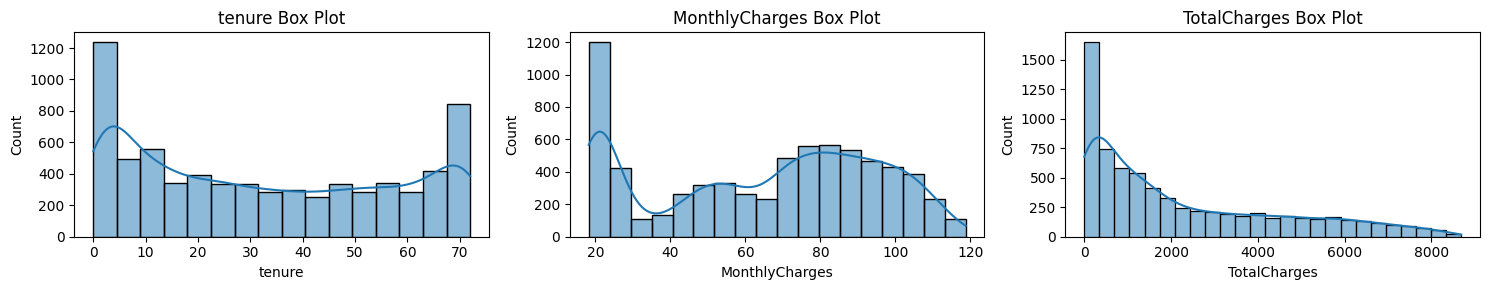

In [12]:
# Distribution of Numericals
n_cols = 3
n_rows = len(num_cols) // n_cols + (1 if len(num_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

for i, column in enumerate(num_cols):
    row_index = i // n_cols
    col_index = i % n_cols
    
    sns.histplot(x=df[column], ax=axs[col_index], kde=True)
    axs[col_index].set_title(f"{column} Box Plot")
    

for i in range(len(num_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

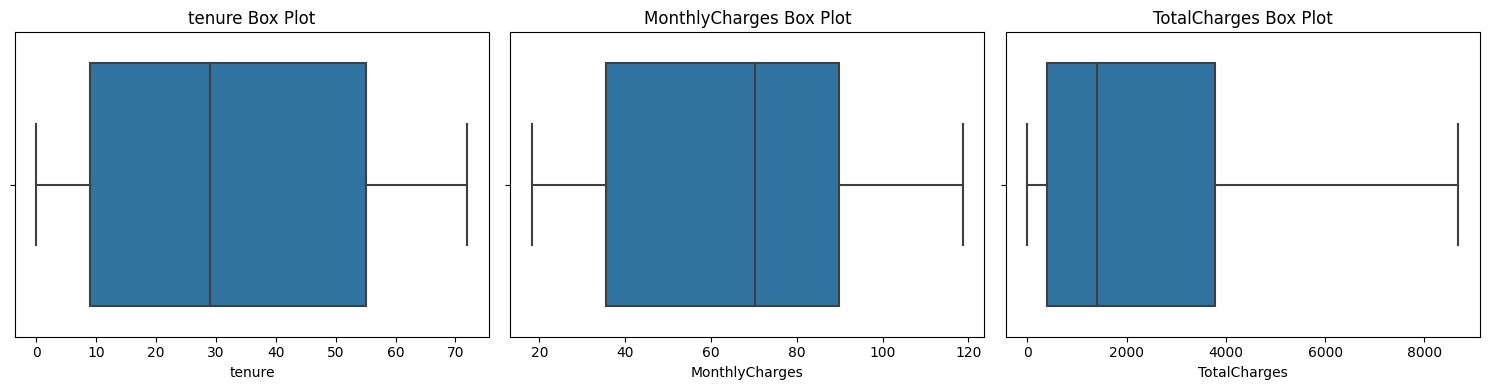

In [13]:
# Box plot of Numericals
n_cols = 3
n_rows = len(num_cols) // n_cols + (1 if len(num_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

for i, column in enumerate(num_cols):
    row_index = i // n_cols
    col_index = i % n_cols
    
    sns.boxplot(x=df[column], ax=axs[col_index])
    axs[col_index].set_title(f"{column} Box Plot")
    

for i in range(len(num_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

## Categorical Analysis

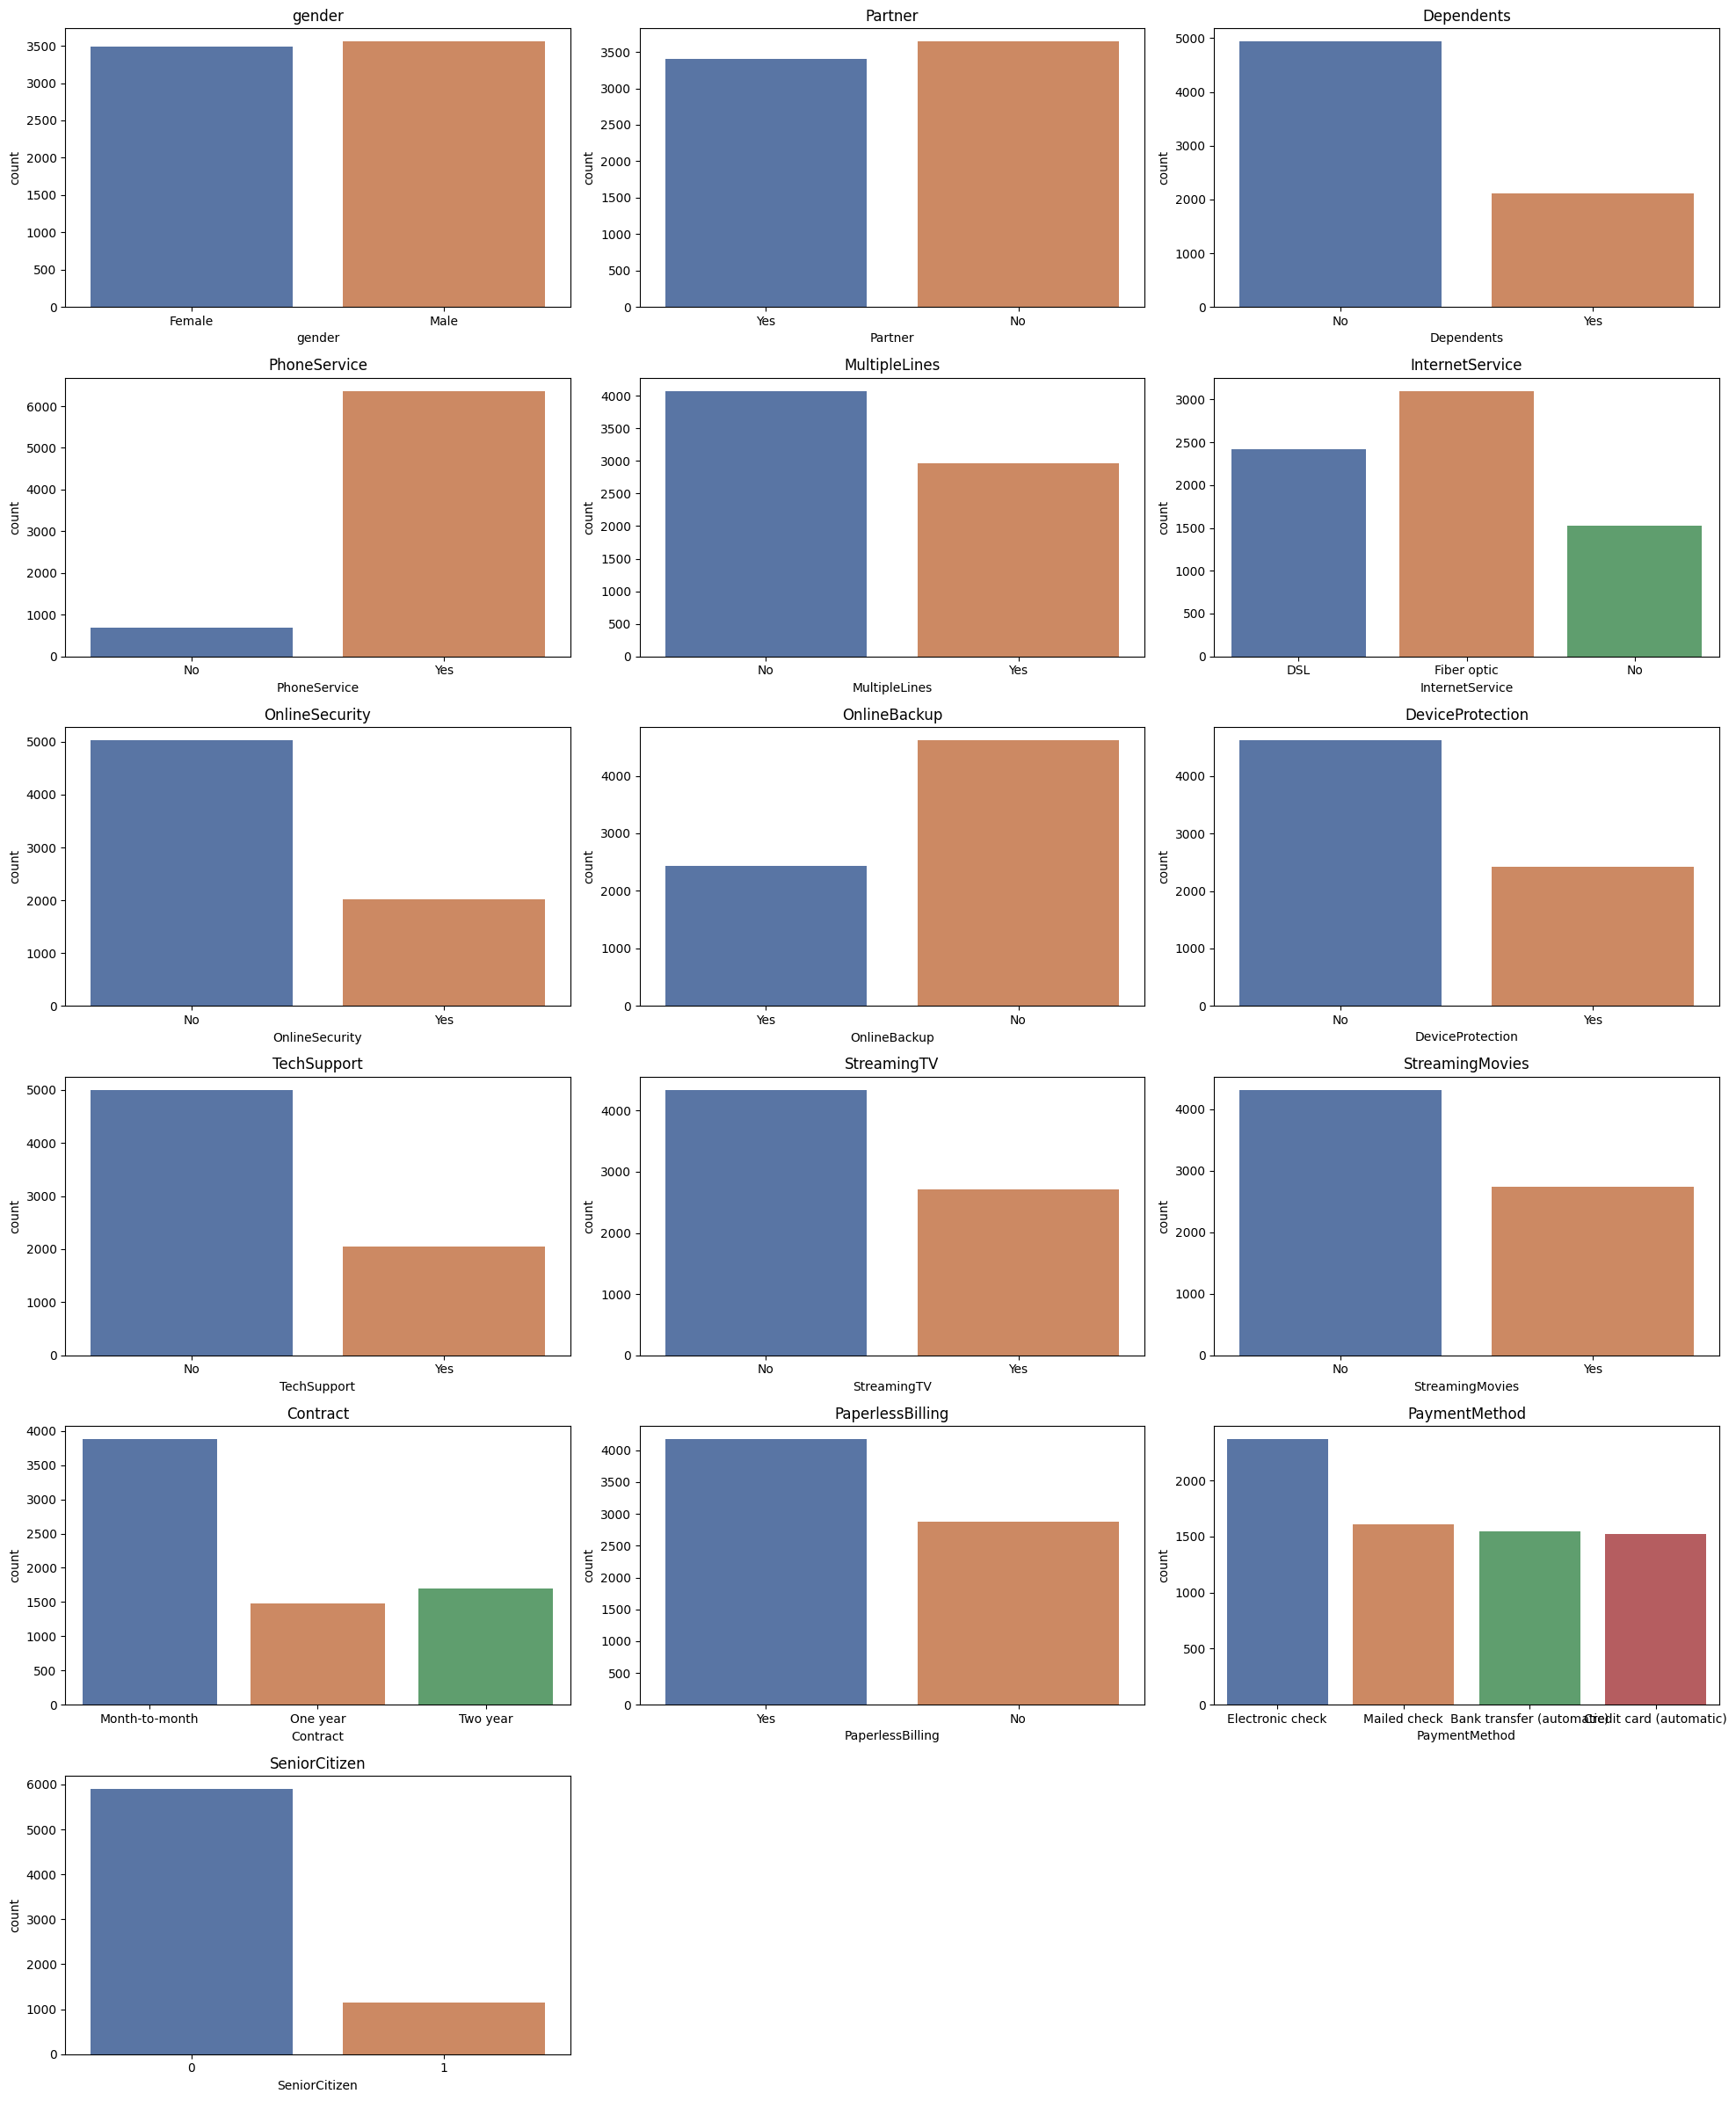

In [14]:
# Countplot of Categorical
n_cols = 3
n_rows = len(cat_cols) // n_cols + (1 if len(cat_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

for i, column in enumerate(cat_cols):
    row_index = i // n_cols
    col_index = i % n_cols
    
    sns.countplot(x=df[column], ax=axs[row_index, col_index], palette="deep")
    axs[row_index, col_index].set_title(f"{column}")
    

for i in range(len(cat_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

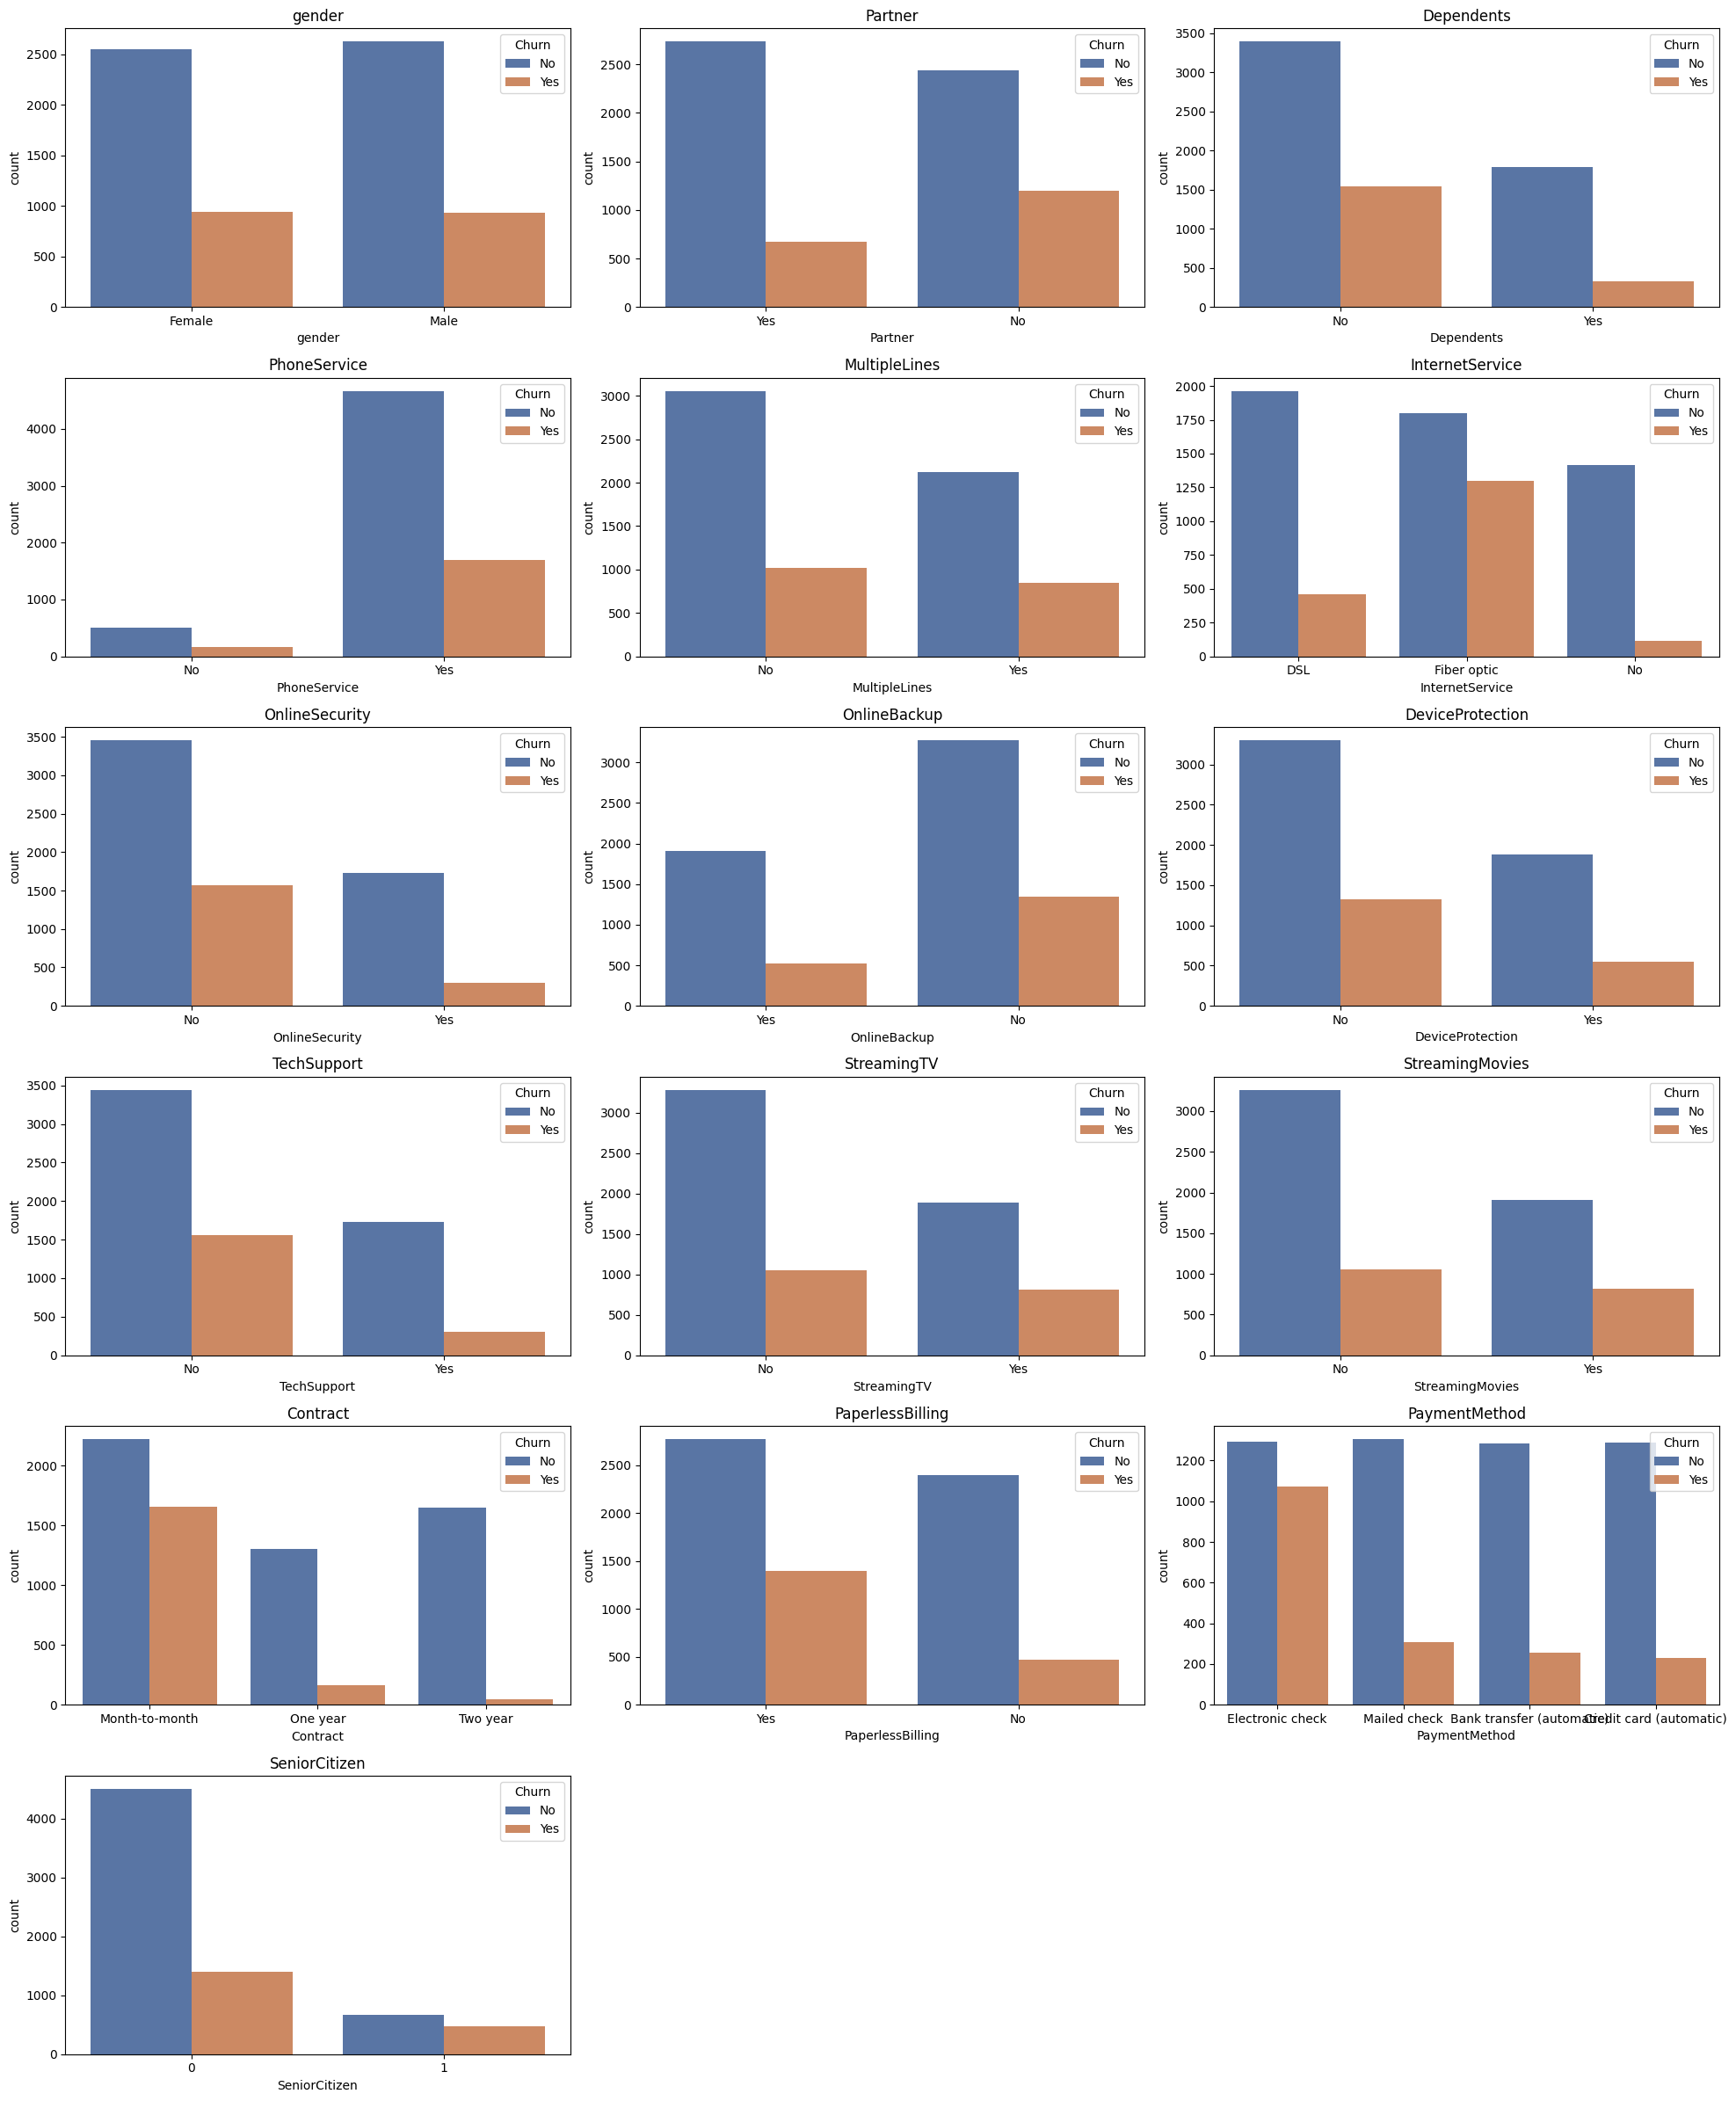

In [15]:
# How Categorical Variables effects on Churn
n_cols = 3
n_rows = len(cat_cols) // n_cols + (1 if len(cat_cols) % n_cols > 0 else 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

for i, column in enumerate(cat_cols):
    row_index = i // n_cols
    col_index = i % n_cols
    
    sns.countplot(x=df[column], ax=axs[row_index, col_index], hue=df[target], palette="deep")
    axs[row_index, col_index].set_title(f"{column}")
    

for i in range(len(cat_cols), n_cols * n_rows):
    fig.delaxes(plt.gca())

plt.tight_layout()
plt.show()

# Target Analysis

In [16]:
per_target = (df[target].value_counts() * 100) / df.shape[0]
count_target = df[target].value_counts()

df_target = pd.concat([count_target, per_target], axis=1, keys=["count", "percentage"])
df_target.head()
df_target = df_target.reset_index()

In [17]:
fig = px.pie(df_target, values="count", names="Churn", title='Churn Rates')
fig.show()

* We have imbalanced data set

In [18]:
df.groupby(target)[num_cols].mean()

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.569965,61.265124,2549.911442
Yes,17.979133,74.441332,1531.796094


In [19]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
# to analyse how cat_cols effect target, we need to do label encoding

# Label Encoding
le = LabelEncoder()

for col in binary_cols:
    df[col] = le.fit_transform(df[col])

for col in binary_cols:
    print(df.groupby(col).agg({"Churn": ["mean", "count"]}))
    print("\n#############################\n")

           Churn      
            mean count
gender                
0       0.269209  3488
1       0.261603  3555

#############################

                  Churn      
                   mean count
SeniorCitizen                
0              0.236062  5901
1              0.416813  1142

#############################

            Churn      
             mean count
Partner                
0        0.329580  3641
1        0.196649  3402

#############################

               Churn      
                mean count
Dependents                
0           0.312791  4933
1           0.154502  2110

#############################

                 Churn      
                  mean count
PhoneService                
0             0.249267   682
1             0.267096  6361

#############################

                  Churn      
                   mean count
MultipleLines                
0              0.250246  4072
1              0.286099  2971

########################

- Old customer has 41% of churn rate. 
- Tech support may positively affect effect on Churn (customer receiving no tech support has 31% churn rate)
- Online security may positively affect on Churn (customer who has no online security has 31% churn rate).
- Dependents may positively affect on Churn (customer who has no dependents has 31% churn rate).
- PaperlessBilling may negatively affect on Churn (customer who has paperless billing has 33% churn rate).

In [21]:
for col in ohe_cols:
    print(df.groupby(col).agg({"Churn": ["mean", "count"]}))
    print("\n#############################\n")

                    Churn      
                     mean count
InternetService                
DSL              0.189591  2421
Fiber optic      0.418928  3096
No               0.074050  1526

#############################

                   Churn      
                    mean count
Contract                      
Month-to-month  0.427097  3875
One year        0.112695  1473
Two year        0.028319  1695

#############################

                              Churn      
                               mean count
PaymentMethod                            
Bank transfer (automatic)  0.167098  1544
Credit card (automatic)    0.152431  1522
Electronic check           0.452854  2365
Mailed check               0.191067  1612

#############################



- Interestingly, customer receiving Fiber optic has 41% churn rate.
- Month-to-month contracts may negatively affect on Churn with 42% churn rate.
- Electronic check payment method may also negatively affect on Churn with 45% churn rate.

# Data Preprocessing

In [22]:
# Outlier functions
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [23]:
for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


- There is no outlier value in our dataset.

# Base Model Pipeline

In [24]:
# Base model(without scaling)

models = [("LR", LogisticRegression()),
         ("KNN", KNeighborsClassifier()),
         ("CART", DecisionTreeClassifier()),
         ("RF", RandomForestClassifier()),
         ("GBM", GradientBoostingClassifier()),
         ("XGB", XGBClassifier()),
         ("LGBM", LGBMClassifier(verbose=-1)),
         ("ADA", AdaBoostClassifier()),
         ("CatBoost", CatBoostClassifier(verbose=False))
          ]
transformer = ColumnTransformer([("OHE", OneHotEncoder(drop="if_binary"), ohe_cols)], 
                                remainder="passthrough")

X = df.drop([target, "customerID"], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

for name, model in models:
    
    pipe = Pipeline([("transformer", transformer),
                    ("model", model)])
    
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    print(f"{name} Recall -> {cv_result.mean()}\n")

LR Recall -> 0.5297658862876253

KNN Recall -> 0.4367892976588629

CART Recall -> 0.49565217391304345

RF Recall -> 0.4802675585284281

GBM Recall -> 0.5083612040133779

XGB Recall -> 0.5010033444816053

LGBM Recall -> 0.5036789297658862

ADA Recall -> 0.5250836120401338

CatBoost Recall -> 0.494314381270903



<div class="alert alert-block alert-info">
    <b>Tip:</b> The important metric for us in churn problems is the <b>recall score</b>. Because we need to be able to identify the Churn ones (True Positive) and ensure that the company does not lose profit.</div>

<div class="alert alert-block alert-success">
According to base models, <b>LogisticRegression</b> perform the best recall score.
</div>

# Using *scale_pos_weight*  parameter to deal with Imbalanced Data

- scale_pos_weight is an XGBoost (eXtreme Gradient Boosting) parameter that is used especially in a classification problem with unbalanced classes. XGBoost is a tree-based learning algorithm for dealing with weighted classes. The scale_pos_weight parameter helps you determine how to weight the instances of the positive class relative to the negative class.
- A classification problem with unbalanced classes refers to a situation where the positive class has fewer instances than the negative class. In such cases, you may want to increase the model's ability to correctly classify the positive class. The scale_pos_weight parameter can correct this imbalance.
- The value of scale_pos_weight specifies how much heavier the negative class should be than the positive class. For example, if the positive class is rarer, you can set scale_pos_weight to reflect the rarity of the positive class relative to the negative class. This can help the model emphasize the positive class more and help you achieve a more balanced result.

In [25]:
df_ = df.copy()

In [26]:
# XGBoost, LightGBM, CatBoost

# we set the parameter from default(1) to 5

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_ = one_hot_encoder(df_, ohe_cols, drop_first=True)

X = df_.drop([target, "customerID"], axis=1)
y = df_[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=101) # for reset previous MinMaxScaler standartization

col_names = ["Accuracy", "Recall", "Roc_Auc", "Precision"]
result_df = pd.DataFrame(columns = col_names)
index_mapping = {0: "scale_pos_weight : 1" , 1: 'scale_pos_weight: 2', 2: 'scale_pos_weight: 3', 3: "scale_pos_weight: 4", 4: "scale_pos_weight: 5"}


# XGB
for i in range(1,6):
    
    accuracy= []
    recall =[]
    roc_auc= []
    precision = []
    
    xgb = XGBClassifier(random_state=1, scale_pos_weight=i).fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    recall.append(round(recall_score(y_test, y_pred),4))
    roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
    precision.append(round(precision_score(y_test, y_pred),4))
    
    score_list = [accuracy, recall, roc_auc, precision]
    
    result_df.loc[len(result_df)] = score_list
    
print("---------------XGB---------------\n")
result_df.rename(index= index_mapping)

---------------XGB---------------



,Accuracy,Recall,Roc_Auc,Precision
scale_pos_weight : 1,[0.7686],[0.5134],[0.6871],[0.5714]
scale_pos_weight: 2,[0.7509],[0.6123],[0.7066],[0.5264]
scale_pos_weight: 3,[0.7495],[0.6711],[0.7245],[0.5218]
scale_pos_weight: 4,[0.7374],[0.7005],[0.7256],[0.5038]
scale_pos_weight: 5,[0.7331],[0.738],[0.7347],[0.4982]


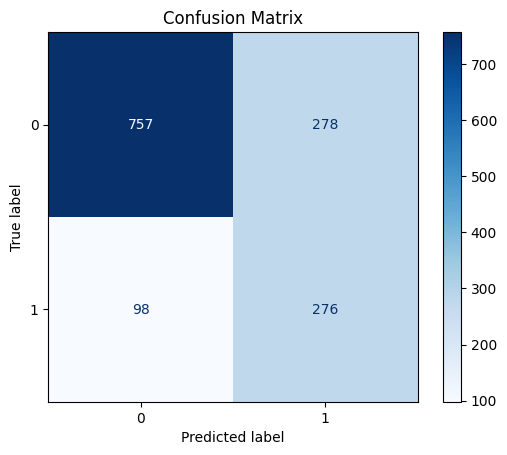

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1035
           1       0.50      0.74      0.59       374

    accuracy                           0.73      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.73      0.75      1409



In [27]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [28]:
col_names = ["Accuracy", "Recall", "Roc_Auc", "Precision"]
result_df = pd.DataFrame(columns = col_names)
index_mapping = {0: "scale_pos_weight : 1" , 1: 'scale_pos_weight: 2', 2: 'scale_pos_weight: 3', 3: "scale_pos_weight: 4", 4: "scale_pos_weight: 5"}


# LGBM
for i in range(1,6):
    
    accuracy= []
    recall =[]
    roc_auc= []
    precision = []
    
    lgb = LGBMClassifier(random_state=1, scale_pos_weight=i).fit(X_train, y_train)
    y_pred = lgb.predict(X_test)
    
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    recall.append(round(recall_score(y_test, y_pred),4))
    roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
    precision.append(round(precision_score(y_test, y_pred),4))
    
    score_list = [accuracy, recall, roc_auc, precision]
    
    result_df.loc[len(result_df)] = score_list
    
print("---------------LightGBM---------------\n")
result_df.rename(index= index_mapping)

---------------LightGBM---------------



,Accuracy,Recall,Roc_Auc,Precision
scale_pos_weight : 1,[0.7757],[0.5027],[0.6885],[0.5912]
scale_pos_weight: 2,[0.748],[0.6658],[0.7218],[0.5198]
scale_pos_weight: 3,[0.7374],[0.7433],[0.7393],[0.5036]
scale_pos_weight: 4,[0.7161],[0.7674],[0.7325],[0.4783]
scale_pos_weight: 5,[0.6962],[0.7727],[0.7207],[0.4573]


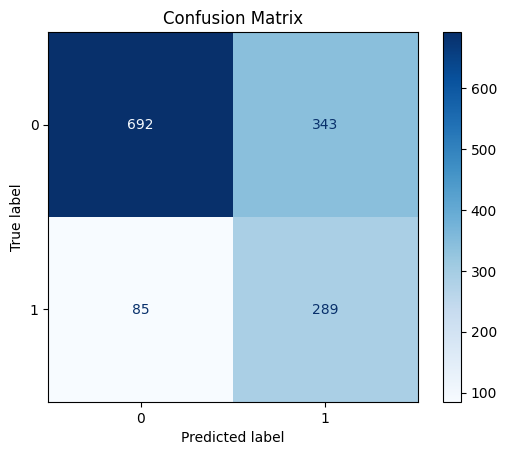

              precision    recall  f1-score   support

           0       0.89      0.67      0.76      1035
           1       0.46      0.77      0.57       374

    accuracy                           0.70      1409
   macro avg       0.67      0.72      0.67      1409
weighted avg       0.78      0.70      0.71      1409



In [29]:
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [30]:
col_names = ["Accuracy", "Recall", "Roc_Auc", "Precision"]
result_df = pd.DataFrame(columns = col_names)
index_mapping = {0: "scale_pos_weight : 1" , 1: 'scale_pos_weight: 2', 2: 'scale_pos_weight: 3', 3: "scale_pos_weight: 4", 4: "scale_pos_weight: 5"}


# CatBoost
for i in range(1,6):
    
    accuracy= []
    recall =[]
    roc_auc= []
    precision = []
    
    cat = CatBoostClassifier(random_state=1, scale_pos_weight=i, verbose=False).fit(X_train, y_train)
    y_pred = cat.predict(X_test)
    
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    recall.append(round(recall_score(y_test, y_pred),4))
    roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
    precision.append(round(precision_score(y_test, y_pred),4))
    
    score_list = [accuracy, recall, roc_auc, precision]
    
    result_df.loc[len(result_df)] = score_list
    
print("---------------CatBoost---------------")
result_df.rename(index= index_mapping)

---------------CatBoost---------------


,Accuracy,Recall,Roc_Auc,Precision
scale_pos_weight : 1,[0.78],[0.516],[0.6957],[0.5994]
scale_pos_weight: 2,[0.7615],[0.6818],[0.7361],[0.5403]
scale_pos_weight: 3,[0.7282],[0.7246],[0.727],[0.4918]
scale_pos_weight: 4,[0.7204],[0.7754],[0.7379],[0.4833]
scale_pos_weight: 5,[0.7005],[0.8048],[0.7338],[0.4631]


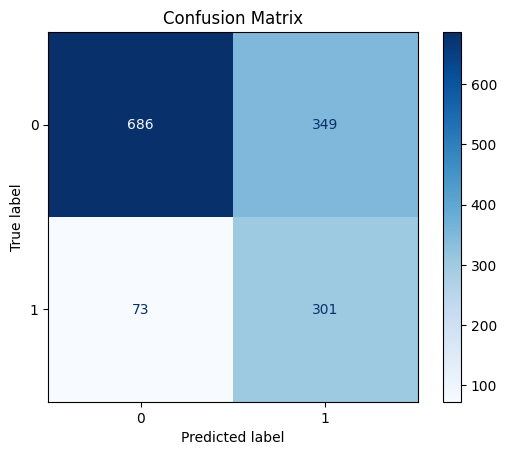

              precision    recall  f1-score   support

           0       0.90      0.66      0.76      1035
           1       0.46      0.80      0.59       374

    accuracy                           0.70      1409
   macro avg       0.68      0.73      0.68      1409
weighted avg       0.79      0.70      0.72      1409



In [31]:
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Model with Scaling

In [32]:
# With Scaling

X = df.drop([target, "customerID"], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

transformer = ColumnTransformer([("OHE", OneHotEncoder(drop="if_binary"), ohe_cols),
                                ("Scaler", MinMaxScaler(), num_cols)], 
                                remainder="passthrough")

for name, model in models:
    
    pipe = Pipeline([("transformer", transformer),
                    ("model", model)])
    
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    print(f"{name} Recall with scaled -> {cv_result.mean()}\n")

LR Recall with scaled -> 0.5311036789297658

KNN Recall with scaled -> 0.5137123745819399

CART Recall with scaled -> 0.5190635451505017

RF Recall with scaled -> 0.47558528428093644

GBM Recall with scaled -> 0.5076923076923077

XGB Recall with scaled -> 0.5010033444816053

LGBM Recall with scaled -> 0.5090301003344482

ADA Recall with scaled -> 0.5250836120401338

CatBoost Recall with scaled -> 0.494314381270903



# Model dealing with imbalanced data using both class_weight="balanced" and scale_pos_weight

- class_weight allow us to adjust class weight. In imbalanced datasets, we can increase the weight of minority class. For example class_weight="balanced" means for both negative and positive class' weights are equal. If we use the parameter like {0:2,1:8} it means that positive class is four time greater than the negative class. 
- class_weight="balanced" captures more true events (higher TRUE recall) but also you are more likely to get false alerts (lower TRUE precision).

In [33]:
# Model dealing with imbalanced using both class_weight="balanced" and scale_pos_weight

models = [("LR", LogisticRegression(class_weight="balanced")),
         ("KNN", KNeighborsClassifier()),
         ("CART", DecisionTreeClassifier(class_weight="balanced")),
         ("RF", RandomForestClassifier(class_weight="balanced")),
         ("GBM", GradientBoostingClassifier()),
         ("XGB", XGBClassifier(eval_metric='mlogloss', scale_pos_weight=5)),
         ("LGBM", LGBMClassifier(verbose=-1, class_weight="balanced")),
         ("ADA", AdaBoostClassifier()),
         ("CatBoost", CatBoostClassifier(scale_pos_weight=5,verbose=False))
          ]

for name, model in models:
    
    pipe = Pipeline([("transformer", transformer),
                    ("model", model)])
    
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    print(f"{name} Recall with both balanced and scaled -> {cv_result.mean()}\n")

LR Recall with both balanced and scaled -> 0.7973244147157191

KNN Recall with both balanced and scaled -> 0.5137123745819399

CART Recall with both balanced and scaled -> 0.4862876254180602

RF Recall with both balanced and scaled -> 0.4682274247491639

GBM Recall with both balanced and scaled -> 0.5070234113712375

XGB Recall with both balanced and scaled -> 0.705685618729097

LGBM Recall with both balanced and scaled -> 0.7217391304347827

ADA Recall with both balanced and scaled -> 0.5250836120401338

CatBoost Recall with both balanced and scaled -> 0.8234113712374581



# Logistic Regression & XGB & LGBM & CatBoost

Text(0.5, 1.0, 'LogisticRegression ROC Curve')

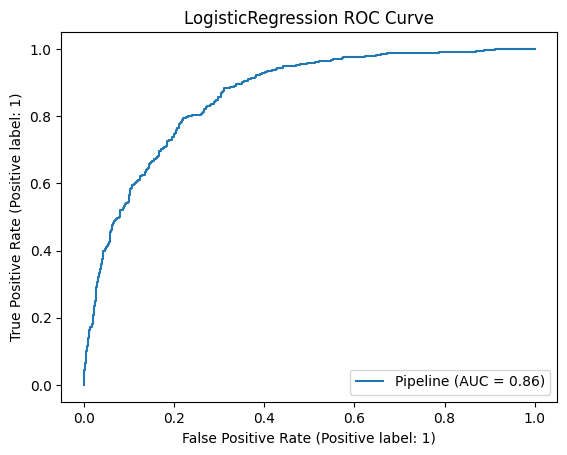

In [34]:
# Logistic Regression
pipe_lr = Pipeline([("transformer", transformer),
                   ("clf", LogisticRegression(class_weight="balanced"))])

y_pred_lr = pipe_lr.fit(X_train, y_train).predict(X_test)

RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.title("LogisticRegression ROC Curve")

In [35]:
# LR Scores
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1035
           1       0.52      0.81      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



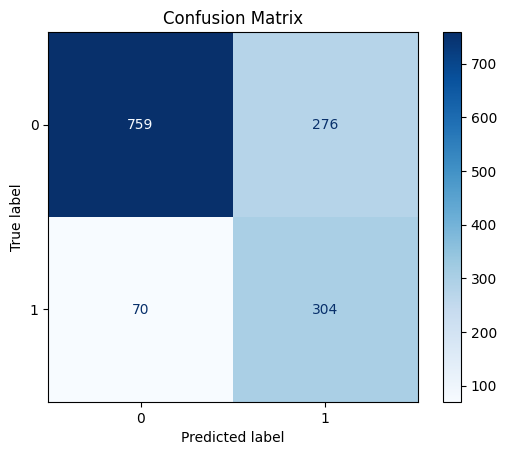

In [36]:
plot_confusion_matrix(y_test, y_pred_lr)

Text(0.5, 1.0, 'XGB ROC Curve')

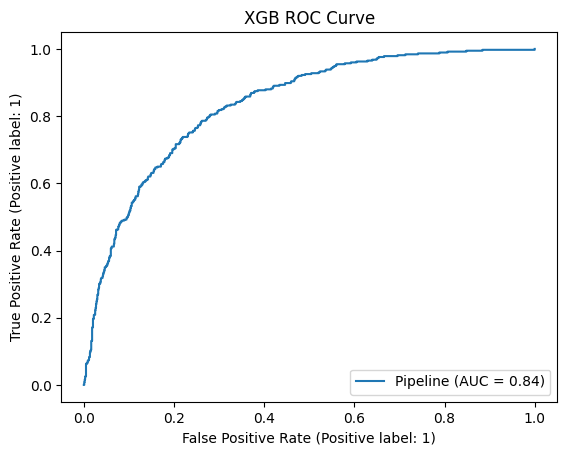

In [37]:
# XGBoost 
pipe_xgb = Pipeline([("transformer", transformer),
                   ("clf", XGBClassifier(eval_metric="mlogloss", scale_pos_weight=5))])

y_pred_xgb = pipe_xgb.fit(X_train, y_train).predict(X_test)

RocCurveDisplay.from_estimator(pipe_xgb, X_test, y_test)
plt.title("XGB ROC Curve")

In [38]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.77      1409



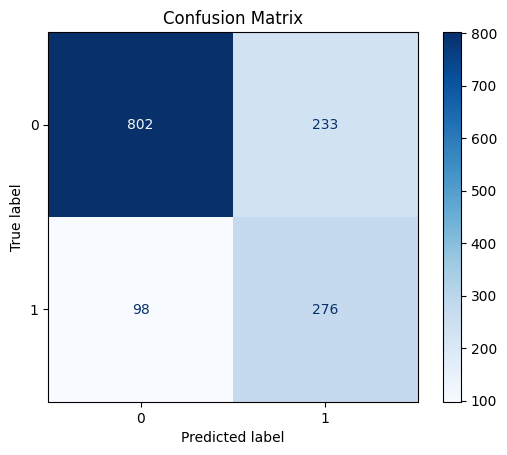

In [39]:
plot_confusion_matrix(y_test, y_pred_xgb)

Text(0.5, 1.0, 'LGBM ROC Curve')

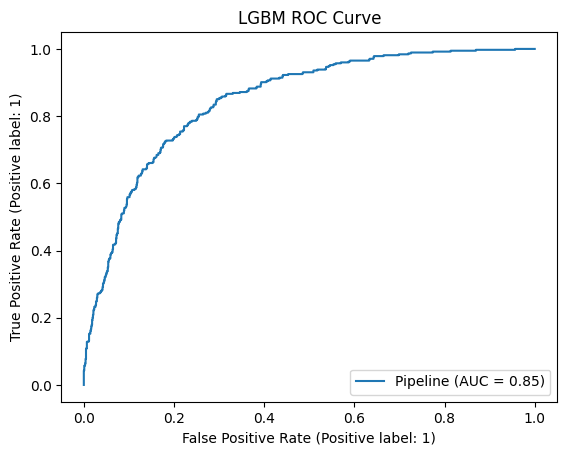

In [40]:
# LGBM
pipe_lgb = Pipeline([("transformer", transformer),
                   ("clf", LGBMClassifier(scale_pos_weight=5, verbose=-1))])

y_pred_lgb = pipe_lgb.fit(X_train, y_train).predict(X_test)

RocCurveDisplay.from_estimator(pipe_lgb, X_test, y_test)
plt.title("LGBM ROC Curve")

In [41]:
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1035
           1       0.51      0.85      0.64       374

    accuracy                           0.74      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.82      0.74      0.76      1409



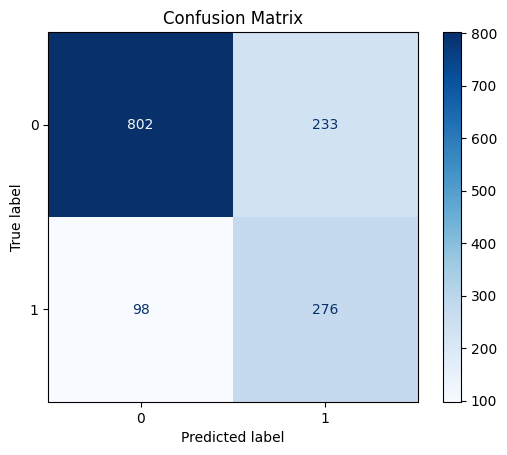

In [42]:
plot_confusion_matrix(y_test, y_pred_xgb)

Text(0.5, 1.0, 'CatBoost ROC Curve')

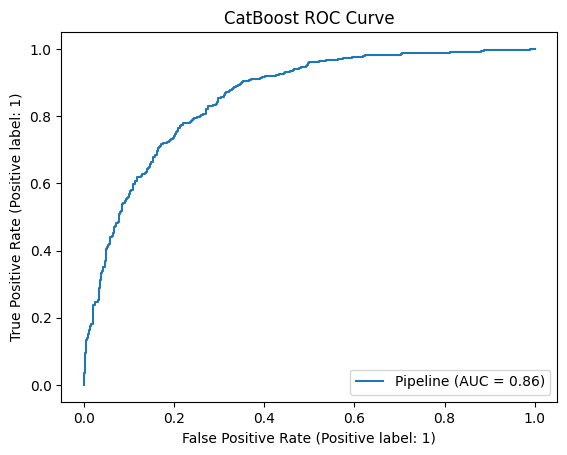

In [43]:
pipe_cat = Pipeline([("transformer", transformer),
                   ("clf", CatBoostClassifier(scale_pos_weight=5,verbose=False))
                   ])

y_pred_cat = pipe_cat.fit(X_train, y_train).predict(X_test)

RocCurveDisplay.from_estimator(pipe_cat, X_test, y_test)
plt.title("CatBoost ROC Curve")

In [44]:
# CatBoost Scores
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      1035
           1       0.50      0.86      0.63       374

    accuracy                           0.74      1409
   macro avg       0.72      0.78      0.71      1409
weighted avg       0.82      0.74      0.75      1409



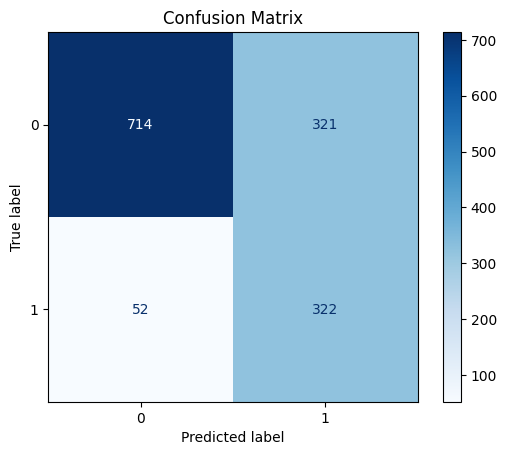

In [45]:
plot_confusion_matrix(y_test, y_pred_cat)

# Hyperparameter Optimization for LightGBM

In [46]:
pipe_lgb.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('OHE', OneHotEncoder(drop='if_binary'),
                                    ['InternetService', 'Contract',
                                     'PaymentMethod']),
                                   ('Scaler', MinMaxScaler(),
                                    ['tenure', 'MonthlyCharges', 'TotalCharges'])])),
  ('clf', LGBMClassifier(scale_pos_weight=5, verbose=-1))],
 'verbose': False,
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('OHE', OneHotEncoder(drop='if_binary'),
                                  ['InternetService', 'Contract',
                                   'PaymentMethod']),
                                 ('Scaler', MinMaxScaler(),
                                  ['tenure', 'MonthlyCharges', 'TotalCharges'])]),
 'clf': LGBMClassifier(scale_pos_weight=5, verbose=-1),
 'transformer__n_jobs': None,
 

In [47]:
lightgbm_params = {"clf__learning_rate": [0.01, 0.1],
                   "clf__n_estimators": [100, 300, 500, 1000, 2000],
                   "clf__colsample_bytree": [0.7, 1],
                   "clf__scale_pos_weight": [5],
                   "clf__max_depth": [-1, 2, 4, 8]
                   }
                   
                   

gs_lgb = GridSearchCV(pipe_lgb, lightgbm_params, cv=kfold, scoring="recall").fit(X_train, y_train)

gs_lgb.best_params_

{'clf__colsample_bytree': 0.7,
 'clf__learning_rate': 0.01,
 'clf__max_depth': 2,
 'clf__n_estimators': 300,
 'clf__scale_pos_weight': 5}

# Final Model & Performance & Validation

Text(0.5, 1.0, 'LGBM Final ROC Curve')

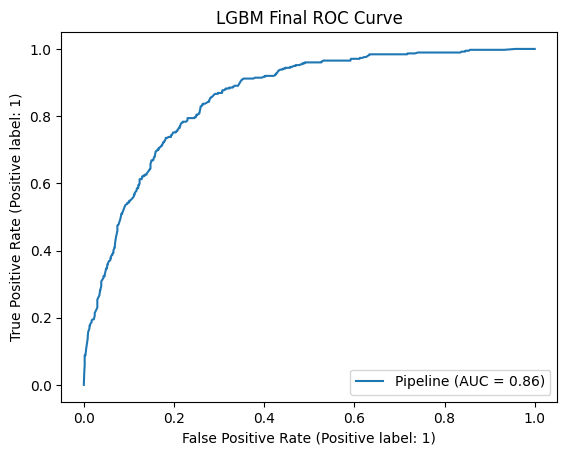

In [48]:
lgbm_final = pipe_lgb.set_params(**gs_lgb.best_params_).fit(X_train, y_train)

y_pred_final = lgbm_final.predict(X_test)

RocCurveDisplay.from_estimator(lgbm_final, X_test, y_test)
plt.title("LGBM Final ROC Curve")

In [49]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.96      0.56      0.71      1035
           1       0.44      0.94      0.60       374

    accuracy                           0.66      1409
   macro avg       0.70      0.75      0.65      1409
weighted avg       0.82      0.66      0.68      1409



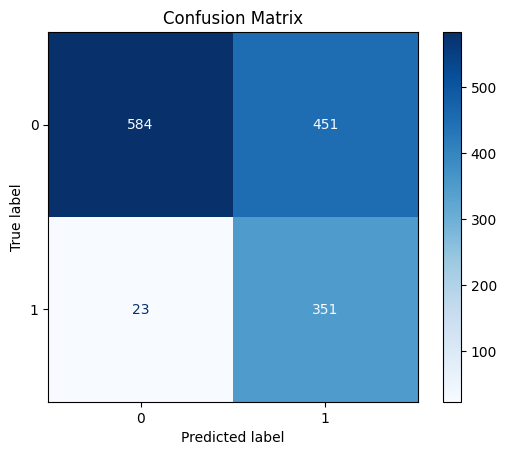

In [50]:
plot_confusion_matrix(y_test, y_pred_final)

In [51]:
cv_result = cross_val_score(lgbm_final, X_train, y_train, cv=kfold, scoring="recall")
print(cv_result)
print(cv_result.mean())

[0.89966555 0.90635452 0.90301003 0.90635452 0.90301003]
0.9036789297658864


# Saving Models

In [52]:
import joblib

joblib.dump(lgbm_final, "pipeline_with_lgbm.pkl")

['pipeline_with_lgbm.pkl']

# Results

- The important metric for us in churn problems is the <b>Recall Score (TP/ TP + FN)</b> because we need to be able to identify the Churn ones (True Positive) and ensure that the company does not lose profit.

- CatBoostClassifier performs with <b>0.86 Recall Score.</b>

- LightGBM performs with <b> 0.85 Recall Score. </b>

- LogisticRegression performs with <b> 0.81 Recall Score </b>.

- XGBoost performs with <b> 0.74 Recall Score </b>.

- <code style="background:green;color:white">Final LightGBM Model is optimized with GridSearchCV to increase the recall score from 0.86 to 0.94.</code>

## If you like the notebook, I would be very grateful if you upvote it. If you have any question feel free to comment. Happy kaggling :)